In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns 
from PIL import Image 
from datetime import datetime 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
from pathlib import Path
from math import sqrt
from tqdm import tqdm
tqdm.pandas()


# Import data Path

In [2]:
data_path = Path("/Users/me./Desktop/Spring '22 /Machine Learning/Project/h-and-m-personalized-fashion-recommendations/")
N =12

# Read Data

Join data by customer_id

In [3]:
df = pd.read_csv(data_path / 'transactions_train.csv' , usecols = ['t_dat' , 'customer_id', 'article_id'], dtype = {'article_id' :str})

In [4]:
df['t_dat'] = pd.to_datetime(df['t_dat'])
last_ts = df['t_dat'].max()
min_ts = df['t_dat'].min()

In [13]:
art = pd.read_csv("../Project/h-and-m-personalized-fashion-recommendations/articles.csv")
cust = pd.read_csv("../Project/h-and-m-personalized-fashion-recommendations/customers.csv")
sampl = pd.read_csv("../Project/h-and-m-personalized-fashion-recommendations/sample_submission.csv")
trans = pd.read_csv("../Project/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [15]:
art.head()
art[art['article_id'] == 663713001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
40179,663713001,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,1010016,Solid,9,Black,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."


In [7]:
cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [8]:
trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [9]:
sampl.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


# Feature Manipulation

In [75]:
total_folders = 0 
total_files = 0

folder_info = []
images_names = [] 

for base, dirs, files in tqdm(os.walk(data_path)):
    for directories in dirs:
        folder_info.append((directories, len(os.listdir(os.path.join(base, directories)))))
        total_folders = total_folders +1 
    for fil in files:
        total_files = total_files + 1
        if(len(fil.split('.jpg')) == 2):
            images_names.append(fil.split('.jpg')[0])

88it [00:00, 188.04it/s]


In [76]:
print(f'- Total numer of folders: {total_folders}')
print(f'- Total number of files: {total_files}')


- Total numer of folders: 87
- Total number of files: 105105


Find missing data 

In [16]:
def missing_data(data): 
    total = data.isnull().sum().sort_values(ascending = False) 
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys =['Total', 'Percent']) 

In [19]:
missing_data(art).head(5)

,Total,Percent
detail_desc,416,0.394156
perceived_colour_master_name,0,0.000000
garment_group_name,0,0.000000
garment_group_no,0,0.000000
section_name,0,0.000000


In [20]:
missing_data(cust).head(5)

,Total,Percent
Active,907576,66.150819
FN,895050,65.237831
fashion_news_frequency,16009,1.166854
age,15861,1.156066
club_member_status,6062,0.441843


In [21]:
missing_data(trans).head(5)

,Total,Percent
t_dat,0,0.0
customer_id,0,0.0
article_id,0,0.0
price,0,0.0
sales_channel_id,0,0.0


Find unique values

In [17]:
def unique_values (data): 
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns: 
        unique = data[col].nunique()
        uniques.append(unique) 
    tt['Uniques'] = uniques
    return tt 

In [22]:
unique_values(art).head(5)

,Total,Uniques
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131


In [23]:
unique_values(cust).head()

,Total,Uniques
customer_id,1371980,1371980
FN,476930,1
Active,464404,1
club_member_status,1365918,3
fashion_news_frequency,1355971,4


In [24]:
unique_values(trans).head()

,Total,Uniques
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


Can see not all customers are purchasing from H&M. Also not all articles are being purchased 

# Data Visualization 

# Articles 


Pie charts

In [55]:
def pie_chart(df, col_values, labels, ax, color, title): 
    n_classes = len(df)
    explode = (0.1,) *n_classes 
    ax.pie(df[col_values], colors = color, explode = explode, labels = df[labels], shadow = True) 
    ax.set_title(title, fontsize = 16) 
    

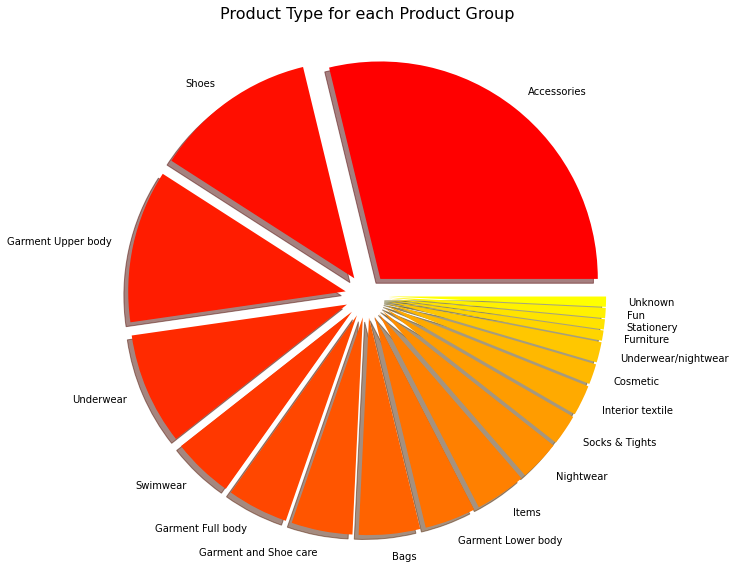

In [34]:
temp = art.groupby(['product_group_name'])['product_type_name'].nunique()
tdf = pd.DataFrame({'Product Group': temp.index, 'Product Types': temp.values})
tdf = tdf.sort_values(['Product Types'], ascending = False) 

fig,axes  = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10)) 
color = plt.cm.autumn(np.linspace(0, 1, len(tdf)))

pie_chart(tdf, 'Product Types', 'Product Group', axes, color, 'Product Type for each Product Group') 


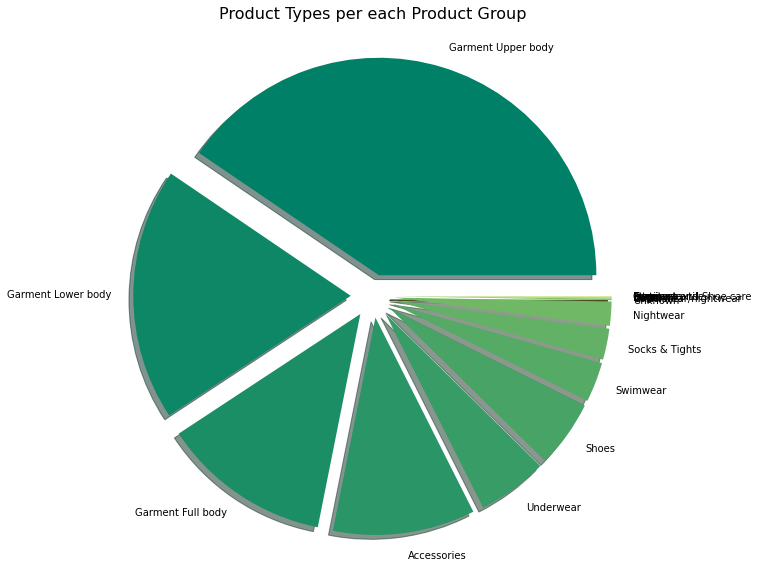

In [36]:
temp = art.groupby(['product_group_name'])['article_id'].nunique()
tdf = pd.DataFrame({'Product Group': temp.index, 'Articles': temp.values})
tdf = tdf.sort_values(['Articles'], ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
color = plt.cm.summer(np.linspace(0, 1, len(tdf)))

pie_chart(tdf, 'Articles','Product Group', axes, color, 'Product Types per each Product Group') 


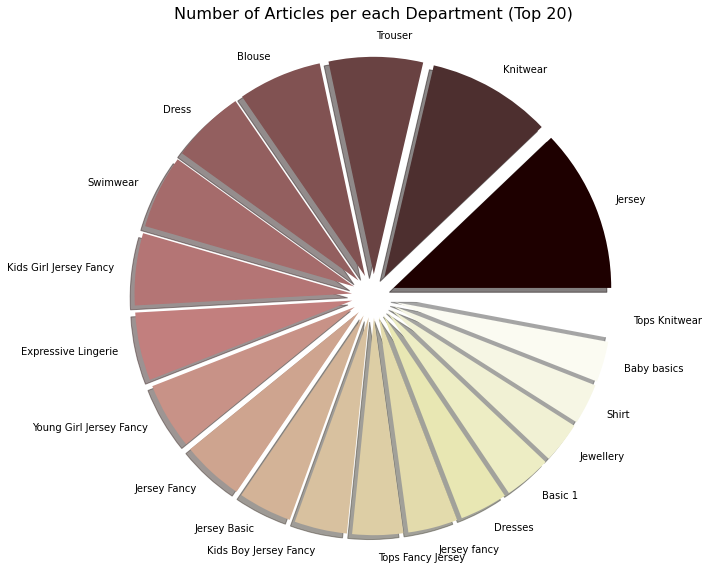

In [41]:
temp = art.groupby(['department_name'])['article_id'].nunique()
tdf = pd.DataFrame({'Department Name': temp.index, 'Articles': temp.values})
# total_dep = len(tdf['Department Name'].nunique())
tdf = tdf.sort_values(['Articles'], ascending = False).head(20) 

fig,axes = plt.subplots(nrows= 1, ncols =1, figsize = (22,10))
color = plt.cm.pink(np.linspace(0, 1, len(tdf)))

pie_chart(tdf, 'Articles', 'Department Name', axes, color, 'Number of Articles per each Department (Top 20)')

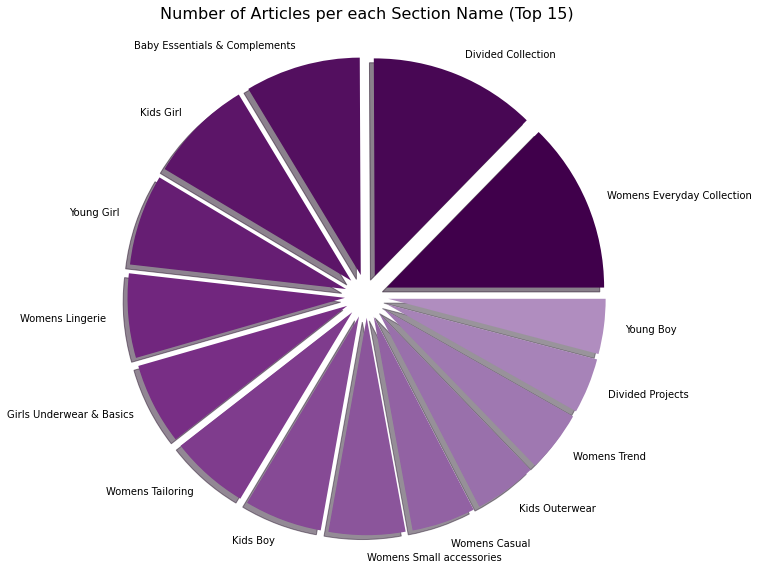

In [43]:
temp = art.groupby(['section_name'])['article_id'].nunique()
tdf = pd.DataFrame({'Section Name': temp.index, 'Articles': temp.values})
tdf = tdf.sort_values(['Articles'], ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(22,10))
color = plt.cm.PRGn(np.linspace(0, 1, len(tdf)))

pie_chart(tdf.head(15), 'Articles', 'Section Name', axes, color, 'Number of Articles per each Section Name (Top 15)') 



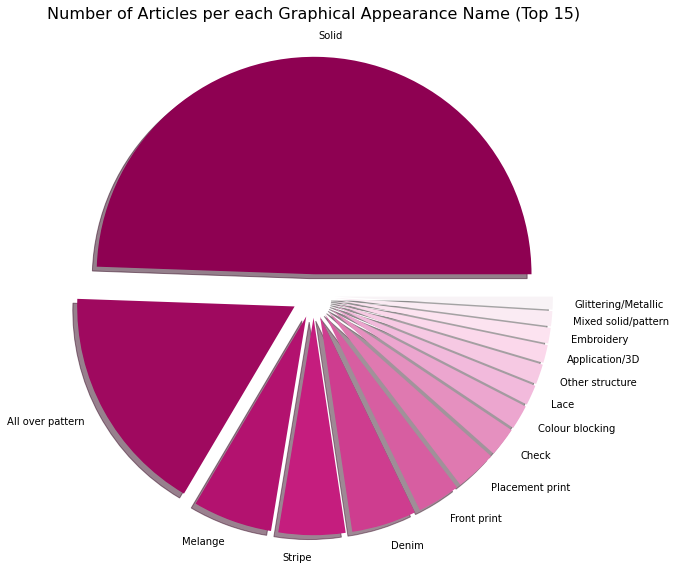

In [44]:
temp = art.groupby(['graphical_appearance_name'])['article_id'].nunique()
tdf = pd.DataFrame({'Graphical Appearance Name' : temp.index , 'Articles' : temp.values})
tdf = tdf.sort_values(['Articles'], ascending = False).head(50) 

fig,axes = plt.subplots(nrows = 1, ncols = 1 , figsize= (22,10))
color = plt.cm.PiYG(np.linspace(0, 1, len(tdf)))

pie_chart(tdf.head(15), 'Articles', 'Graphical Appearance Name', axes, color, "Number of Articles per each Graphical Appearance Name (Top 15)")


Bar charts

In [49]:
def bar_plot(df, col_x, col_y, ax, color, title): 
    ax.bar(x = df[col_x], height = df[col_y], color = color) 
    ax.set_title(title, fontsize = 16) 
    plt.xticks(rotation = 90) 

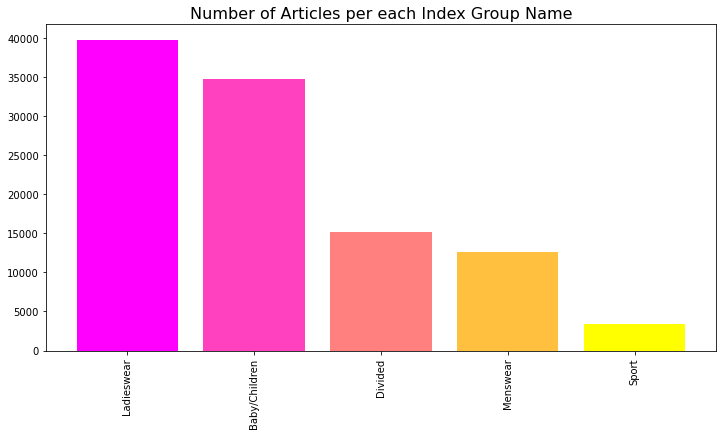

In [50]:
temp = art.groupby(['index_group_name'])['article_id'].nunique()
tdf = pd.DataFrame({'Index Group Name': temp.index, 'Articles': temp.values})
tdf = tdf.sort_values(['Articles'], ascending = False) 

fig,axes = plt.subplots(nrows =1, ncols = 1, figsize = (12,6))
color = plt.cm.spring(np.linspace(0, 1, len(tdf)))

bar_plot(tdf, 'Index Group Name', 'Articles', axes, color, "Number of Articles per each Index Group Name") 


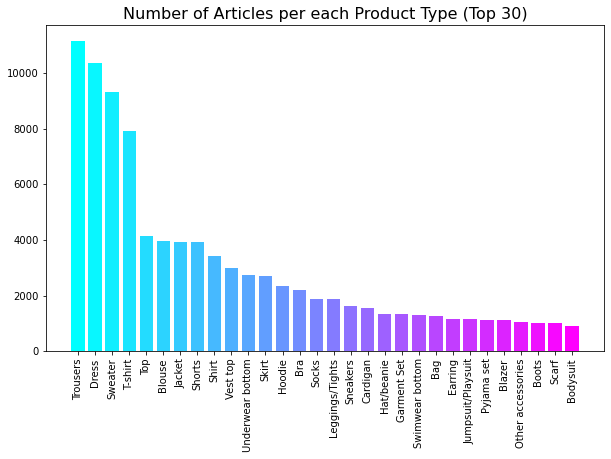

In [54]:
temp = art.groupby(['product_type_name'])['article_id'].nunique() 
tdf = pd.DataFrame({'Product Type': temp.index, 'Articles': temp.values}) 
# total_types = len(df['Product Type'].unique())
tdf = tdf.sort_values(['Articles'], ascending = False)[0:30] 

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize =(10,6))
color = plt.cm.cool(np.linspace(0, 1, len(tdf)))

bar_plot(tdf, 'Product Type', 'Articles', axes, color, "Number of Articles per each Product Type (Top 30)")

Word Cloud

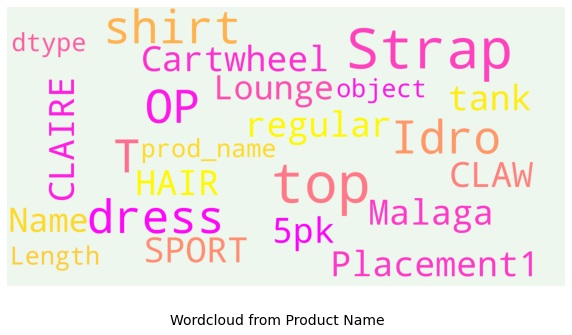

In [47]:
stopwords = set(STOPWORDS)
def show_wordcloud (data, title = None): 
    wordcloud = WordCloud(background_color= '#edf7ee', stopwords= stopwords, max_words = 400, max_font_size= 40, scale=5, colormap='spring', random_state=1).generate(str(data))

    fig = plt.figure(1, figsize = (10,10))
    plt.axis('off')
    if title:  
        fig.suptitle(title, fontsize = 14)
        fig.subplots_adjust(top = 2.3) 
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(art['prod_name'], 'Wordcloud from Product Name') 

# Customers


Pie charts

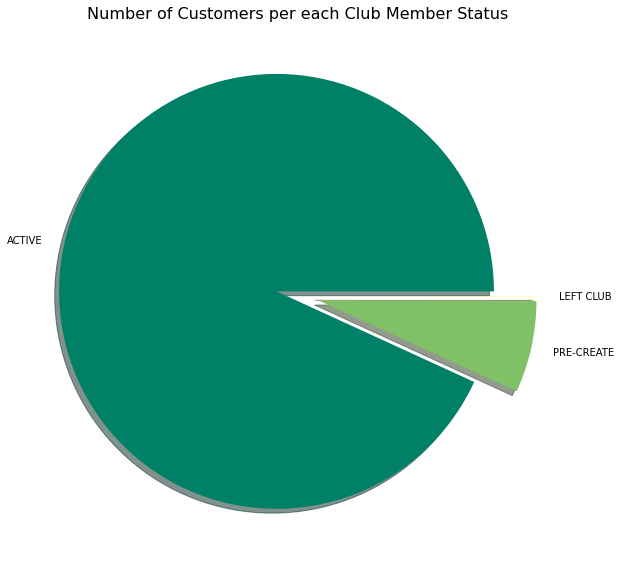

In [58]:
temp = cust.groupby(['club_member_status'])['customer_id'].count()
tdf = pd.DataFrame({'Club Member Status': temp.index, 'Customers': temp.values})
tdf = tdf.sort_values(['Customers'], ascending = False) 

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(22,10))
color =plt.cm.summer(np.linspace(0, 1, len(tdf)))

pie_chart(tdf.head(15), 'Customers', 'Club Member Status', axes, color, "Number of Customers per each Club Member Status")


Bar charts

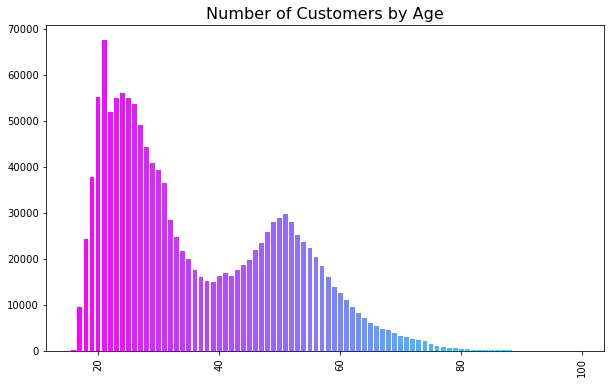

In [59]:
temp = cust.groupby(['age'])['customer_id'].count()
tdf = pd.DataFrame({'Age': temp.index, 'Customers': temp.values})
tdf = tdf.sort_values(['Age'], ascending = False)

fig, axes = plt.subplots(nrows =1, ncols = 1, figsize = (10,6))
color = plt.cm.cool(np.linspace(0, 1, len(tdf)))

bar_plot(tdf, 'Age', 'Customers', axes, color, 'Number of Customers by Age') 

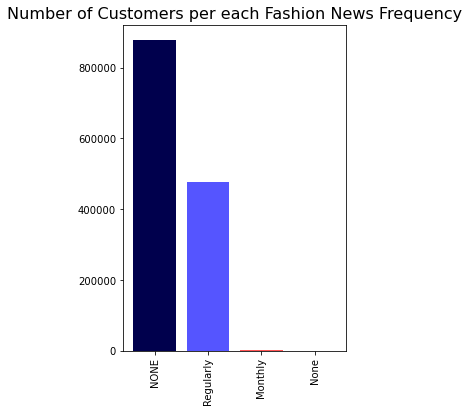

In [61]:
temp = cust.groupby(['fashion_news_frequency'])['customer_id'].count()
tdf = pd.DataFrame({'Fashion News Frequency': temp.index, 'Customers': temp.values})
tdf = tdf.sort_values(['Customers'], ascending= False)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(4,6))
color = plt.cm.seismic(np.linspace(0, 1, len(tdf)))

bar_plot(tdf, 'Fashion News Frequency', 'Customers', axes, color, 'Number of Customers per each Fashion News Frequency') 


# Transactions

Charts

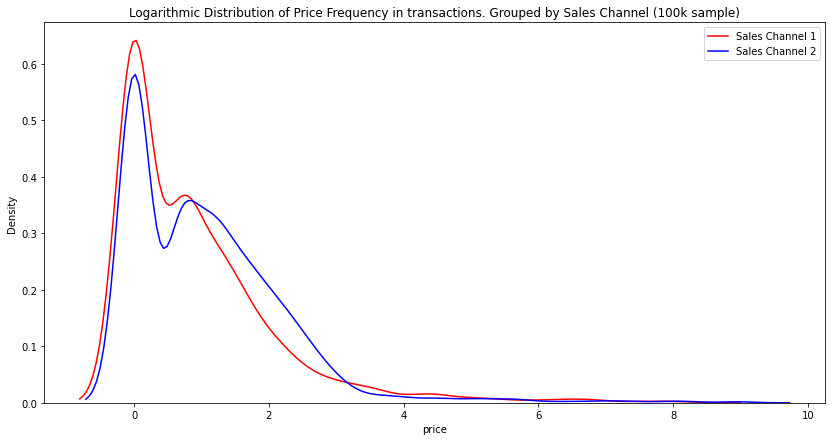

In [64]:
tdf = trans.sample(100_000) 
fig, ax = plt.subplots(1, 1, figsize=(14,7))

sns.kdeplot(np.log(tdf.loc[tdf['sales_channel_id'] ==1].price.value_counts()),color = 'red')
sns.kdeplot(np.log(tdf.loc[tdf['sales_channel_id'] ==2].price.value_counts()),color = 'blue')

ax.legend(labels = ['Sales Channel 1', 'Sales Channel 2'])

plt.title('Logarithmic Distribution of Price Frequency in transactions. Grouped by Sales Channel (100k sample)')
plt.show()


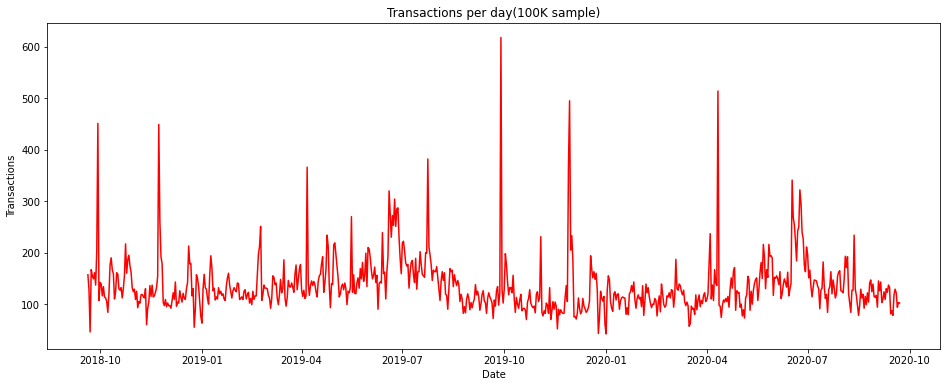

In [65]:
tdf = trans.sample(100_000).groupby(['t_dat'])['article_id'].count().reset_index()
tdf['t_dat'] = tdf['t_dat'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

tdf.columns = ['Date', 'Transactions'] 

fig,axes = plt.subplots(1, 1, figsize= (16,6))
plt.plot(tdf['Date'], tdf['Transactions'], color = 'red') 
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title(f'Transactions per day(100K sample)')
plt.show()

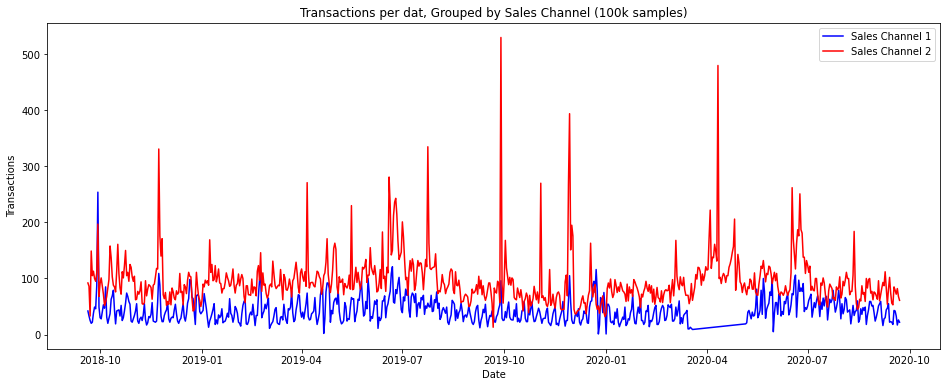

In [67]:
tdf = trans.sample(100_000).groupby(['t_dat', 'sales_channel_id'])['article_id'].count().reset_index()
tdf['t_dat'] = tdf['t_dat'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

tdf.columns = ['Date', 'Sales Channel ID', 'Transactions'] 
fig, axes = plt.subplots(1, 1, figsize =(16,6))
g1 = axes.plot(tdf.loc[tdf['Sales Channel ID'] ==1, 'Date'], tdf.loc[tdf['Sales Channel ID'] ==1, 'Transactions'], label = 'Sales Channel 1', color = 'Blue')
g2 = axes.plot(tdf.loc[tdf['Sales Channel ID'] ==2, 'Date'], tdf.loc[tdf['Sales Channel ID']==2, 'Transactions'], label= 'Sales Channel 2', color ='Red')

plt.xlabel('Date')
plt.ylabel('Transactions')
axes.legend()
plt.title(f'Transactions per dat, Grouped by Sales Channel (100k samples)')
plt.show()

No handles with labels found to put in legend.


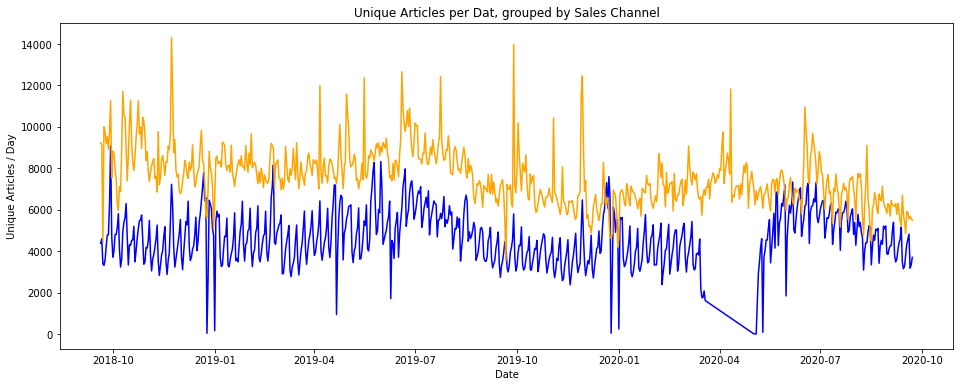

In [71]:
tdf = trans.groupby(['t_dat', 'sales_channel_id'])['article_id'].nunique().reset_index()
tdf['t_dat'] = tdf['t_dat'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
tdf.columns = ['Date', 'Sales Channel ID', 'Unique Articles']

fig, axes = plt.subplots(1, 1, figsize= (16,6))

g1= axes.plot(tdf.loc[tdf['Sales Channel ID'] ==1, 'Date'], tdf.loc[tdf['Sales Channel ID'] ==1, 'Unique Articles'], label= 'Sales Channel 1', color= 'Blue') 
g2= axes.plot(tdf.loc[tdf['Sales Channel ID'] ==2, 'Date'], tdf.loc[tdf['Sales Channel ID'] ==2, 'Unique Articles'], label= 'Sales Channel 2', color = 'Orange')
plt.xlabel('Date')
plt.ylabel('Unique Articles / Day')
ax.legend()
plt.title(f'Unique Articles per Dat, grouped by Sales Channel')
plt.show()

# Image Data

In [80]:
img_name= pd.DataFrame(images_names, columns= ['image_name'])
img_name['article_id'] = img_name['image_name'].apply(lambda x: int(x[1:]))

img_name.head().style.set_properties()

,image_name,article_id
0,0249136006,249136006
1,0244267027,244267027
2,0244267032,244267032
3,0240670058,240670058
4,0241436001,241436001


In [81]:
img_art= art[['article_id', 'product_code','product_group_name','product_type_name']].merge(img_name, on= ['article_id'], how='left')
img_art.head()

,article_id,product_code,product_group_name,product_type_name,image_name
0,108775015,108775,Garment Upper body,Vest top,0108775015
1,108775044,108775,Garment Upper body,Vest top,0108775044
2,108775051,108775,Garment Upper body,Vest top,0108775051
3,110065001,110065,Underwear,Bra,0110065001
4,110065002,110065,Underwear,Bra,0110065002


In [82]:
#products without images
art_no_img = img_art.loc[img_art.image_name.isna()]
art_no_img.head()

,article_id,product_code,product_group_name,product_type_name,image_name
88,174057028,174057,Nightwear,Pyjama jumpsuit/playsuit,NaN
117,179208001,179208,Garment Lower body,Leggings/Tights,NaN
258,212042043,212042,Shoes,Sneakers,NaN
259,212042066,212042,Shoes,Sneakers,NaN
261,212629004,212629,Garment Full body,Dress,NaN


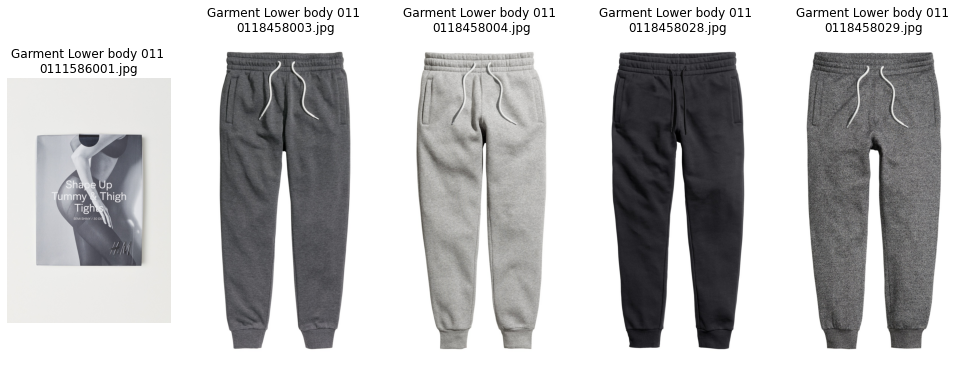

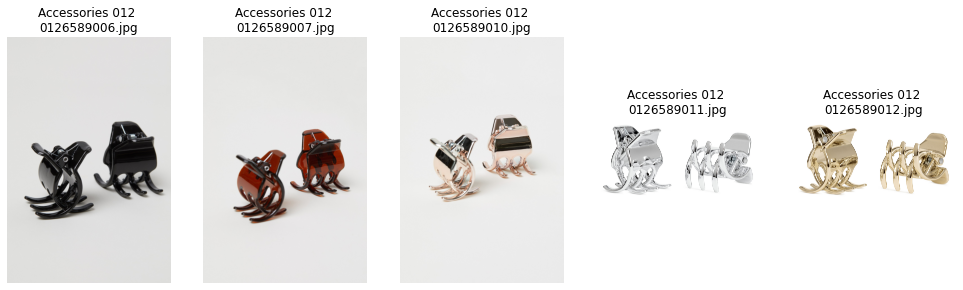

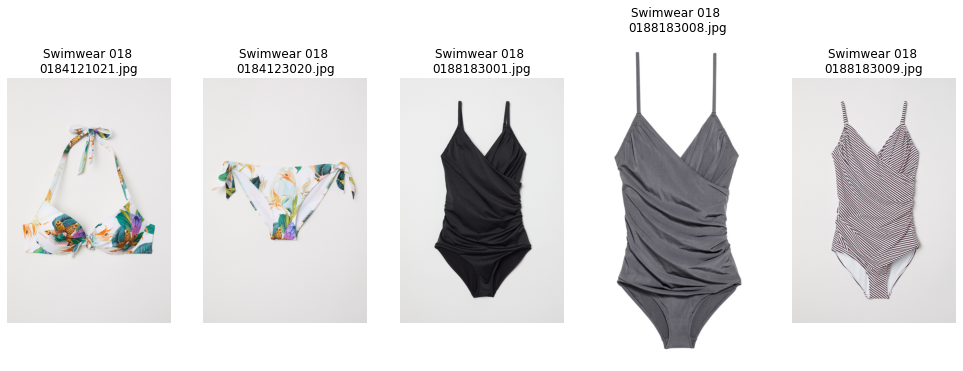

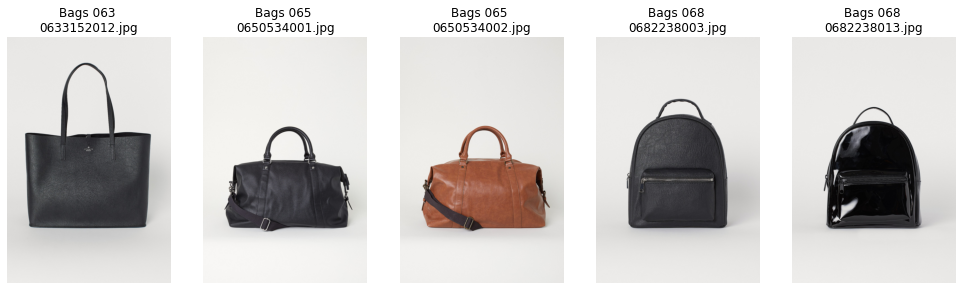

In [98]:
#Show image data 
def plot_img(img_artdf, product_group_name, cols = 1, rows= -1):
    img_path = '../Project/h-and-m-personalized-fashion-recommendations/images/'
    ddf = img_artdf.loc[img_artdf.product_group_name == product_group_name]
    article_ids = ddf.article_id.values[0: cols*rows]
    plt.figure(figsize = (2 + 3 * cols, 2 + 4 * rows))
    for i in range(cols*rows):
        article_id = ('0' + str(article_ids[i]))[-10:]
        plt.subplot (rows, cols, i +1)
        plt.axis('off')
        plt.title(f'{product_group_name} {article_id[:3]} \n{article_id}.jpg')
        image = Image.open(f'{img_path}{article_id[:3]}/{article_id}.jpg')
        plt.imshow(image)

plot_img(img_art, "Garment Lower body", 5, 1)
plot_img(img_art, "Accessories", 5, 1)
plot_img(img_art, 'Swimwear', 5, 1)
plot_img(img_art, 'Bags', 5, 1)


# Predictions

In [99]:
trans= trans.sort_values(['customer_id', 't_dat'], ascending = False)
trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
19867243,2019-12-04,ffffd9ac14e89946416d80e791d064701994755c3ab686...,806050001,0.084729,2
27806865,2020-06-22,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,882810001,0.016932,1
25077914,2020-04-25,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,866755002,0.050831,2
24375394,2020-04-09,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,866755002,0.043203,2
24375395,2020-04-09,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,840360003,0.013542,2


Frequently bought Articles 

In [108]:
ldate = trans.t_dat.max()

#find most frequent articles from last transaction date
most_freq_art = list(trans.loc[trans.t_dat == ldate].article_id.value_counts()[0:12].index)
artlist = []
for art in most_freq_art:
    art = '0'+str(art)
    artlist.append(art)
art_str = ' '.join(artlist)

print('Most frequent articles bought on last day of transactions:\n', art_str, end = '\n')



Most frequent articles bought on last day of transactions:
 0924243002 0751471001 0448509014 0918522001 0866731001 0714790020 0788575004 0915529005 0573085028 0918292001 0850917001 0928206001


Show photos of recommended articles
Recommend top 5 articles in product && top 3 articles based on day of purchase
Top Articles last week {Day: Top 3 articles that day} 
Top 5 articles based on [product group] {product group: top 5 articles}
